# Setup

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
import pandas as pd
import seaborn as sns

In [2]:
style.use("fivethirtyeight")

In [20]:
root_path = "/Users/jmcontreras/jm-contreras/"
countries_path = os.path.join(root_path, "COVID-19/csse_covid_19_data")
data_path = os.path.join(root_path, "COVID-19/csse_covid_19_daily_reports")
plots_path = os.path.join(root_path, "bolivia-covid-19/daily_plots")

# Load countries

In [4]:
df_countries = pd.read_csv(
    os.path.join(countries_path, "UID_ISO_FIPS_LookUp_Table.csv")
)

# Load data

In [5]:
df_data = pd.DataFrame()

# Get all files in the data path
fname_list = os.listdir(path=data_path)
fname_list.sort()

for fname in fname_list:
    
    if fname.endswith(".csv"):
        
        # Read CSV
        df_fname = pd.read_csv(
            os.path.join(data_path, fname)
        )
        
        # Filter to specific row(s)
        col_filter = df_fname.columns.values[df_fname.columns.str.contains("Country")][0]
        df_fname_filter = df_fname[df_fname[col_filter] == "Bolivia"]
        
        # Append to single dataframe
        df_data = pd.concat(
            (df_data, df_fname_filter),
        )

# Clean data

In [6]:
# Find columns missing all data and add them to a list of columns to drop
is_null_all = df_data.isnull().all()
cols_to_drop = is_null_all[is_null_all].index.tolist()

# Coalesce country/region and last update columns
df_data["Country_Region"].update(df_data["Country/Region"])
df_data["Last_Update"].update(df_data["Last Update"])

# Extend the list of columns to drop
cols_to_drop.extend(
    [
        "Latitude",
        "Longitude",
        "Lat",
        "Long_",
        "Combined_Key",
        "Last Update",
        "Country/Region",
    ]
)

# Drop these columns
df_data.drop(columns=cols_to_drop, inplace=True)

In [7]:
# Recast dates as datetime
df_data["Last_Update"] = pd.to_datetime(df_data["Last_Update"])

In [8]:
# Drop duplicates and reset the index
df_data.drop_duplicates(inplace=True)

# Prepare data for analysis

In [9]:
# Set date as the index
df_data.set_index(df_data["Last_Update"].dt.date, inplace=True)
df_data.index.name = "Date"

# For dates with multiple rows, keep their most recent row
df_data = df_data.groupby(
    by="Date",
    group_keys=False,
).apply(
    lambda x: x[x["Last_Update"] == x["Last_Update"].max()]
)

# Fill-in missing dates and forward-fill missing values
labels = pd.date_range(start=df_data.index.min(), end=df_data.index.max())
df_data = df_data.reindex(labels=labels, method="ffill")

# Add new cases column
df_data["New"] = df_data["Confirmed"].diff().fillna(value=df_data.iloc[0]["Confirmed"])

# Plot graph

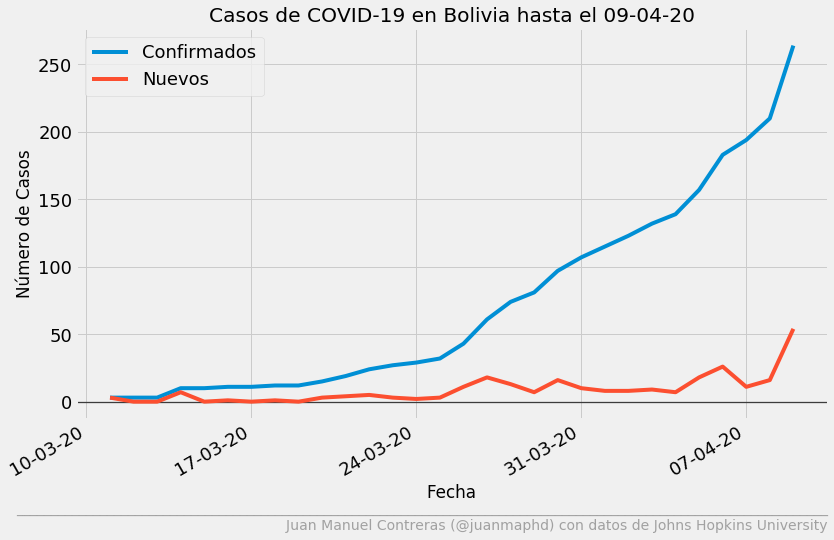

In [28]:
# Create plot object
ax = df_data.plot(
    y=["Confirmed", "New"],
    title=f"Casos de COVID-19 en Bolivia hasta el {df_data.index.max().strftime('%d-%m-%y')}",
    legend=True,
    x_compat=True,
    figsize = (12,8),
)

# Format x-axis ticks and tick labels
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y"))
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)

# Format labels
plt.ylabel("Número de Casos")
plt.xlabel("Fecha")
plt.legend(["Confirmados", "Nuevos"], fontsize=18)

# Add thicker horizontal axis
ax.axhline(
    y=0,
    color="black",
    linewidth=1.3,
    alpha=0.7,
    zorder=1,
)

# Add subtitle
line = "_" * (df_data.shape[0] * 4 - 4)
signature = "Juan Manuel Contreras (@juanmaphd) con datos de Johns Hopkins University"
ax.text(
    x=df_data.index.min() - pd.Timedelta(days=4),
    y=-95,
    s=f"{line}\n{' ' * (df_data.shape[0] * 2)}{signature}",
    color="grey",
    alpha=.7
)

# Draw plot
plt.show()

# Save plot
ax.get_figure().savefig(os.path.join(plots_path, f"bolivia_{df_data.index.max().strftime('%d_%m_%y')}.png"))